<a href="https://www.kaggle.com/code/ritzig/feature-interaction-tutorial-pdp-shap-ensemble-mod?scriptVersionId=117157571" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <b>1 <span style='color:coral'>|</span> Introduction</b>

This notebook is writtern for Tabular Playground Series May 2022 edition. Through this notebook we aim to discover various methods to visualise and understand the feature interactions and how to incorporate them for feature engineering. 

The notebook has end -to -end tutorial covers and explains what is feature interaction and how to analyse and model them using boosting models.

It consists of detailed  EDA , Feature Interaction Analysis, Ensemble Modelling



# <b>2 <span style='color:coral'>|</span> Load Data & Libraries</b>


<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>2.1 | Load Libraries</b></p>
</div>

In [ ]:
!pip install colorama
!pip install mplcyberpunk

In [ ]:
#------------Basic Libraries-------------
import os
import pandas as pd
import numpy as np
##----------- For styling -------------
from colorama import Fore

##--------------Visualization-----
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk
from IPython.display import Image #to display saved image files

## -------------- For feature Interaction------
from sklearn.ensemble import GradientBoostingClassifier


<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:150%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>2.2 | Load Data</b></p>
</div>

In [ ]:
#Load Datapath
DATAPATH = '../input/tabular-playground-series-may-2022'
train = pd.read_csv(os.path.join(DATAPATH,'train.csv'))
test = pd.read_csv(os.path.join(DATAPATH,'test.csv'))

In [ ]:
NCOLS = 40
NROWS = 20
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', NCOLS) 
pd.set_option('display.max_rows', NROWS)

plt.style.use("cyberpunk")

# <b>3 <span style='color:coral'>|</span> Data Exploration</b>

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:200%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>3.1 | Basic EDA</b></p>
</div>

- **Shape of Data** 

  We have 9lakh rows in train and 7 lakh in test with 33 columns including target
- **Missing Values** 

  We have no missing values in test or train!

- **Data Types**

  We have 16 float and 16 integer datatype and 1 object data type `f_27` .  Target Column is a binary datatype
- **Univariate Descriptive Analysis** (mean,median,mode,std)
  
  1. f_28` has highest std deviation and also highest values. 
  2.Features 00-06 and 29,30 have lowest std .
  3. `target` as almost equal distribution of each binary class




In [ ]:
#Shape of Datasets
print(Fore.BLUE+'Shape of Train:'+Fore.RESET,train.shape)
print(Fore.BLUE+'Shape of Test:'+Fore.RESET,test.shape)

In [ ]:
# Columns Datatype info
print(Fore.BLUE+'------Column Info (TRAIN)----------')
train.info()
print(Fore.RED+'\n ------Count of Column Datatypes(TRAIN) ----------')
train.dtypes.value_counts()


In [ ]:
# Columns Datatype info
print(Fore.BLUE+'------Column Info (TEST)----------')
test.info()
print(Fore.RED+'\n ------Count of Column Datatypes(TEST) ----------')
test.dtypes.value_counts()


In [ ]:
train.describe().iloc[1:,1:].sort_values(by='std' , ascending = False,axis=1)\
                       .style.background_gradient(cmap='YlOrBr',axis=1)

In [ ]:
#Checking if dataset is balance or imbalanced
print(Fore.BLUE + 'Value Count of Target class')
train.target.value_counts()

In [ ]:
#Check count of object feature `f_27`
print(Fore.BLUE + 'Value Count of object `f_27` feature')
train.f_27.value_counts()

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:200%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>3.2 | Detailed EDA</b></p>
</div>

**Data Distributions**
  
  Plotting float features and integer features histograms wrt to target class.


In [ ]:
#Custom function to plot histograms
def plot_histograms(data,row,col,targetCol,title):

  f,ax = plt.subplots(row, col, figsize=(25, 30))

  col_iterator =  (c for c in data.columns) #generator expr for iterating columns
  #iterate 
  for r in range(row):
    for c in range(col):
      col_name = col_iterator.__next__()
      sns.histplot(x=data[col_name], hue=data[targetCol],ax=ax[r][c],kde=True)
      ax[r][c].set_title(f'Histogram of {col_name} wrt {targetCol}', fontsize=18)

  plt.suptitle(f'Histograms of {title} Features',weight='bold',fontsize=30)



In [ ]:
features_float = train.select_dtypes('float')
features_float['target'] = train['target']

features_integer = train.select_dtypes('integer')
features_integer['target'] = train['target']
features_integer.drop(columns=['id'],axis=1,inplace=True)

In [ ]:
plot_histograms(features_float,4,4,'target','Float')

In [ ]:
plot_histograms(features_integer,7,2,'target','Integer')

In [ ]:
train_drop_id = train.drop(columns=['id'],axis=1)
corr = train_drop_id.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(25, 15))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(150, 270, as_cmap=True, center='light')
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=0.5,cmap=cmap, center=0,fmt=".2f",
            square=True, linewidths=.5, annot=True, annot_kws={"size": 12}, cbar_kws={"shrink": .2})
plt.show()

# <b>4 <span style='color:coral'>|</span> Feature Interaction</b>

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:200%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>4.1 | What is Feature Interaction?</b></p>
</div>

  We say that a feature is predictive when it has some sort of relationship with the target variable. For example, the price of a car may decrease as the car ages. Age (feature) can be used in a model to predict car price (target variable). In some cases, the relationship between the target variable and feature depends on the value of another feature. *This is known as an interaction between features*.
  
  Feautre interaction can be analysed using :
  * H-Statistic
  * 2-D Partial Dependence Plots
  * SHAP Interactions
  * Scatter Plots based on Target class.

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:200%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>4.2 | H-Statistic</b></p>
</div>
The H-statistic defines the interaction between features as the share of variance that is explained by the interaction.

 In python there is only the `sklearn-gbmi `package that can calculate the H-statistic for Gradient-boosting models.


<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:200%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>4.3 | Partial Dependence Plots</b></p>
</div>

The partial dependence plot (short PDP or PD plot) shows the marginal effect one or two features can have on the predicted outcome of a machine learning model. It can show the nature of relationship between the target and a feature, which could be linear, monotonous or more complex.

The partial dependence plot is a both a global and local method. The method considers all instances and gives a statement about the global relationship of a feature with the predicted outcome (through the yellow line) and the relationship of all the unique instances (rows in the dataframe) with the outcome with the blue lines.

> Here I have tried to plot some features and to check their effect on the model prediction outcome.Note I have used a sample of train dataset **(startified sample)** and not used the full dataset due to computation time. Also we can use the `pdpbox` library to plot the pdp . 


   

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:100%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>4.3.0 | Baseline GBM Model for generation of PDP plots</b></p>
</div>


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import joblib

# fit the model
X_train,Y_train = train.drop(columns=['id','target','f_27'],axis=1),train['target']
gbc = GradientBoostingClassifier(random_state = 2589)
#gbc.fit(X_train,Y_train) # took 15 mins 

#Defining Path to save model 
path = r"../input/models/gbc.joblib"

#Saving Model
#joblib.dump(gbc,path) 

#Loading Saved joblib format of Model
model = joblib.load(path)
X_test = test.drop(columns=['id','f_27'],axis=1)
predictions = model.predict_proba(X_test)[:,1]   #taking probability of predictions
predictions

In [ ]:
#Take sample of train data
train_modified = pd.concat([X_train,Y_train], axis=1)

#Stratified Sampling of Pandas data frame based on `target` column
train_sampled = train_modified.groupby('target', group_keys=False).apply(lambda x: x.sample(frac=0.1)) #taking sample of 50% of data
X_train_sampled = train_sampled.drop(columns=['target'],axis=1)

In [ ]:
#!pip install pdpbox #installing pdpbox

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:100%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>4.3.1 | 1-D PDP </b></p>
</div>

The 1-D PDP plots are similar to ICE (Individual Conditional Expectation) plots except here it averages out all the local effect to give a signle line of global effect of a feature change wrt to prediction probability.

**Observations**

The blue lines show local effects of each datapoint in our sample set and how it affects the prediction probability of our baseline model. The yellow line shows the global effect an agrregate of all local effects
  1. `f_21` as its value increases the prediction prob of class 1 is driven up to value of 0.4 
  2. `f_23` too drives up probabibility as value increases beyond 0 but its effect can be seen minimal as compared to `f_21` with value at end of 0.1 prob
  3. `f_26` too similar to `f_21` drives up the probability with increase in its value with final prob value of 0.4 .
  4. `f_19` unlike earlier features this decreases the probabilty of belonging to class 1 as value of feature increase.  This can be seen in Histogram Plot of Float Features where for `f_19`  the pink kde(class=1) is hsifted towards left i.e. lower value signyfying that lower values of `f_19` have slightly higher prob of belonging to class 1 as compared to higher values of it . But effect of `f_19` is minimal at -0.10

  * If we refer to SHAP Interaction Plot we can see the main effect of `f_21,f_26` are prominent i.e they contribute more to model prediction as compared to `f_19,f_23` and same is reflected in these 1-D PDP plots


In [ ]:
# from pdpbox import pdp, get_dataset, info_plots

# #Generate 1-D PDP Plots
# pdp_rad = pdp.pdp_isolate(model=model, dataset=X_train_sampled, model_features=X_train_sampled.columns, feature='f_21')
# #plot the pdp
# pdp.pdp_plot(pdp_rad, 'f_21', center=True, plot_lines=True, frac_to_plot=100)
# plt.savefig('pdp_one_21.png',bbox_inches='tight')
# plt.show()

Image('../input/plotsfolder/pdp_one_21.png')

In [ ]:
# #Generate 1-d PDP for f_23

# #Generate 1-D PDP Plots
# pdp_rad = pdp.pdp_isolate(model=model, dataset=X_train_sampled, model_features=X_train_sampled.columns, feature='f_23')
# #plot the pdp
# pdp.pdp_plot(pdp_rad, 'f_23', center=True, plot_lines=True, frac_to_plot=100)
# plt.savefig('pdp_one_23.png')
# plt.show()
Image('../input/plotsfolder/pdp_one_23.png')

In [ ]:
# #Generate 1-d PDP for f_26

# #Generate 1-D PDP Plots
# pdp_rad = pdp.pdp_isolate(model=model, dataset=X_train_sampled, model_features=X_train_sampled.columns, feature='f_26')
# #plot the pdp
# pdp.pdp_plot(pdp_rad, 'f_26', center=True, plot_lines=True, frac_to_plot=100)
# plt.savefig('pdp_one_26.png',bbox_inches='tight')
# plt.show()
Image('../input/plotsfolder/pdp_one_26.png')

In [ ]:
# #Generate 1-d PDP for f_19

# #Generate 1-D PDP Plots
# pdp_rad = pdp.pdp_isolate(model=model, dataset=X_train_sampled, model_features=X_train_sampled.columns, feature='f_19')
# #plot the pdp
# pdp.pdp_plot(pdp_rad, 'f_19', center=True, plot_lines=True, frac_to_plot=100)
# plt.savefig('pdp_one_19.png',bbox_inches='tight')
# plt.show()
Image('../input/plotsfolder/pdp_one_19.png')

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:100%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>4.3.2 | 2-D PDP : To view Feature Interactions </b></p>
</div>

We can also plot interactions between features on a through 2-D PDP plots.



> Note: Here I have referred to the SHAP interaction plot from the below notebook 
**Analysing Interactions with SHAP where [@wti200](https://www.kaggle.com/code/wti200/analysing-interactions-with-shap) shows how to analyze feature interactions** 

* **Important Interactions** : `(f_00,f_26)`,`(f_01,f_26)`,`(f_02,f_21)`,`(f_05,f_22)`,`(f_26,f_30)`,`(f_25,f_30)`,`(f_24,f_30)`




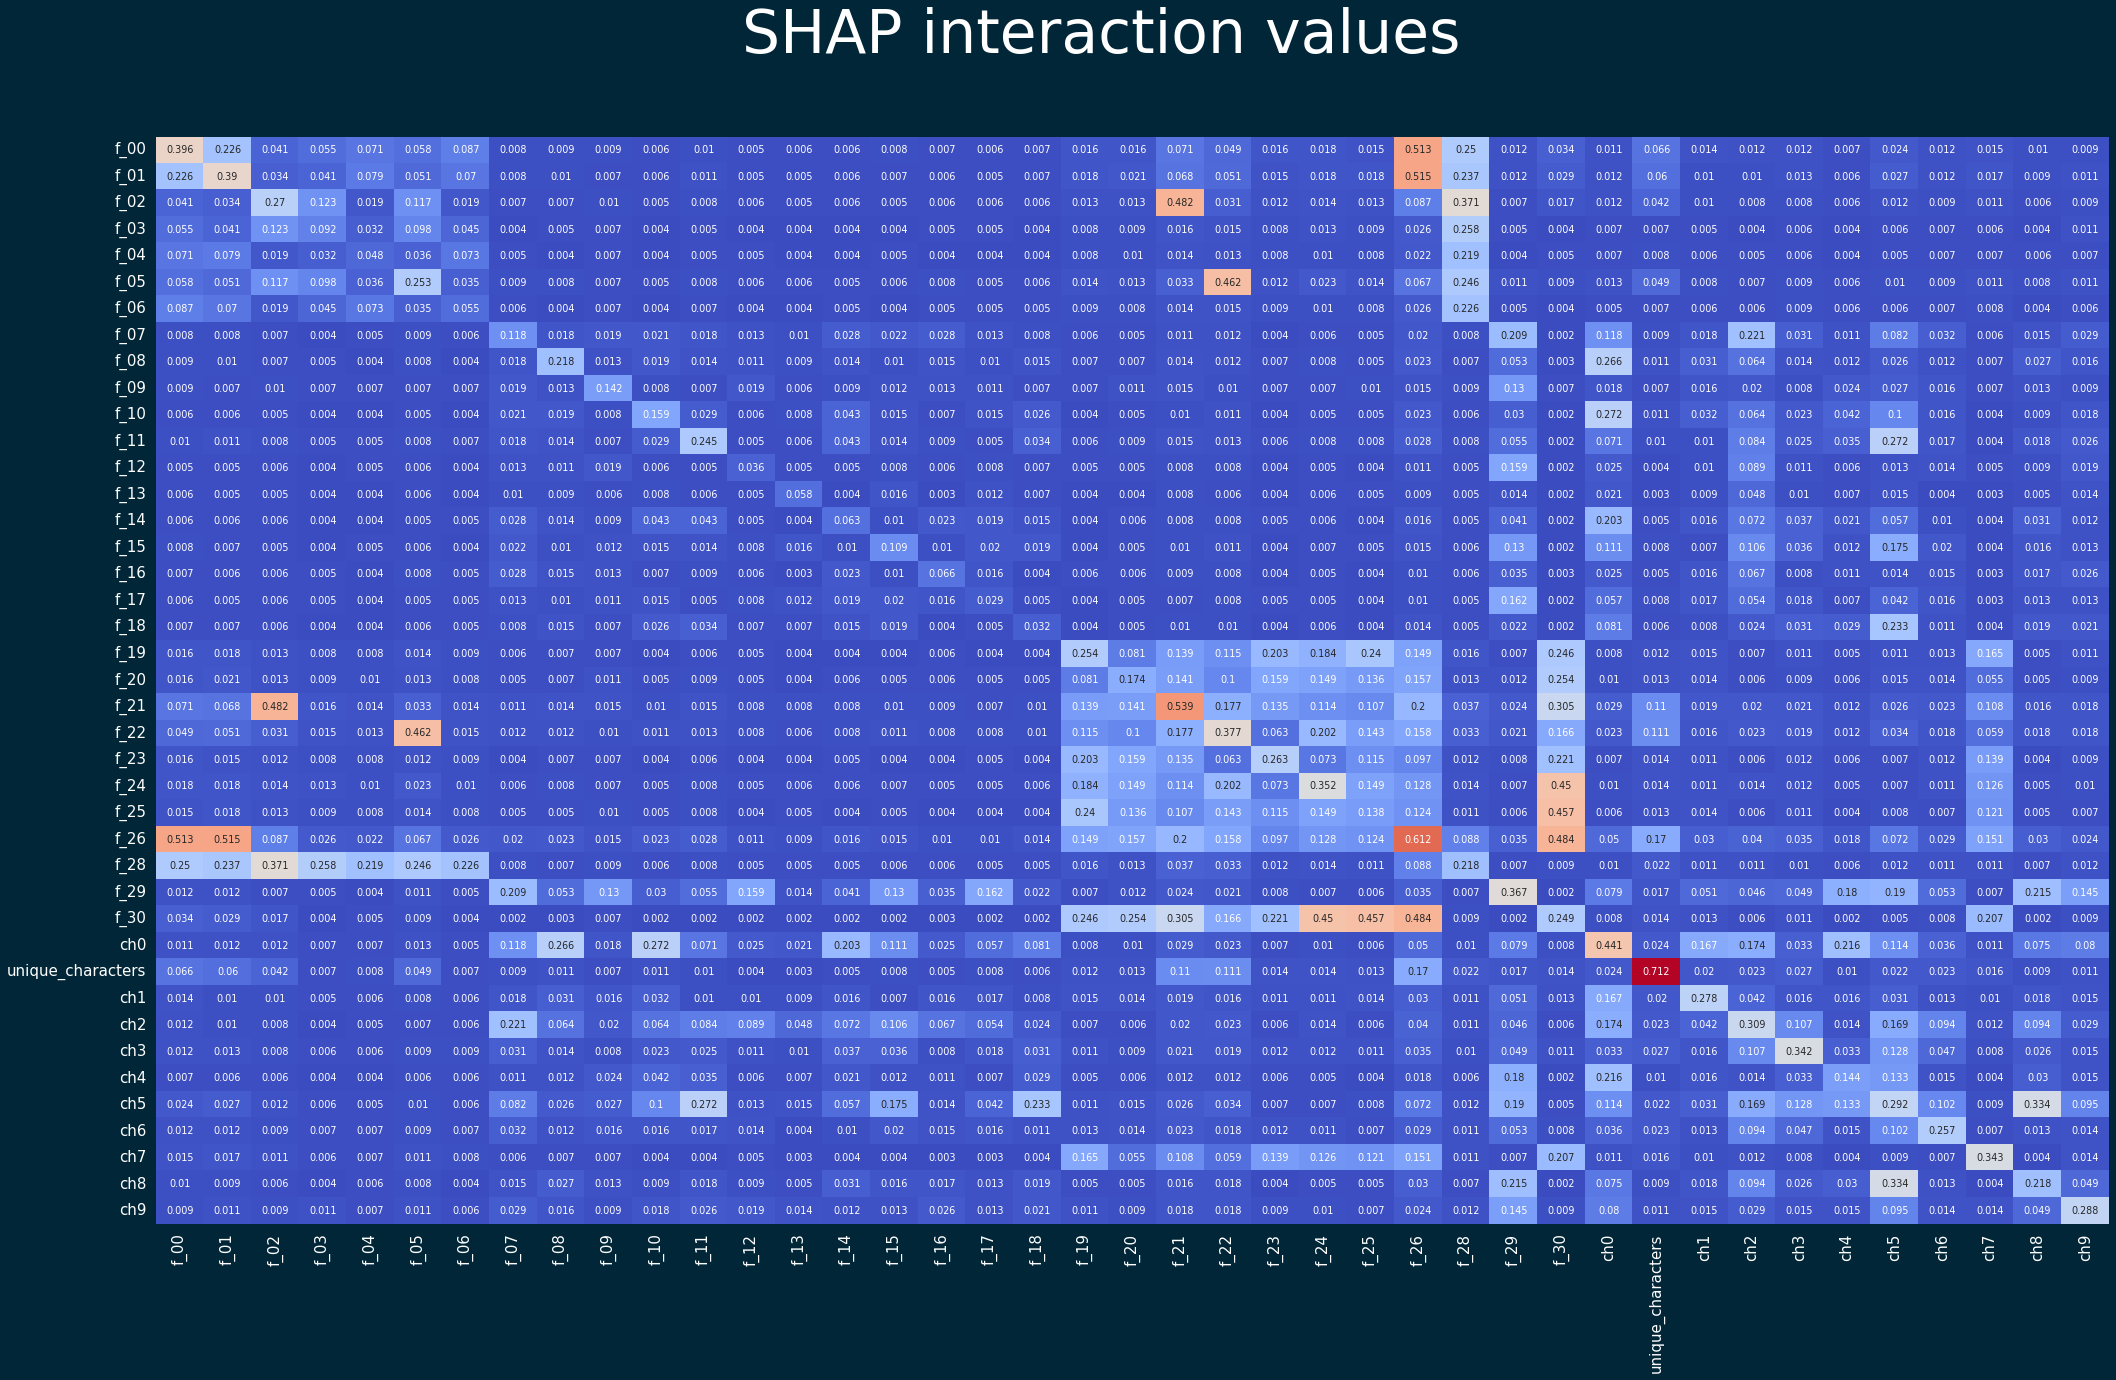

In [ ]:
# features_to_plot = ['f_00', 'f_26']

# inter1  =  pdp.pdp_interact(model=model, dataset=X_train_sampled, model_features=X_train_sampled.columns, features=features_to_plot)

# pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour', x_quantile=False) #plot_pdp=True)
# plt.savefig('pdp_two_1.png',bbox_inches='tight')
# plt.show()
Image('../input/plotsfolder/pdp_two_1.png')

In [ ]:
# features_to_plot = ['f_02', 'f_21']

# inter1  =  pdp.pdp_interact(model=model, dataset=X_train_sampled, model_features=X_train_sampled.columns, features=features_to_plot)
# pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour', x_quantile=False) #plot_pdp=True)
# plt.savefig('pdp_two_2.png',bbox_inches='tight')
# plt.show()
Image('../input/plotsfolder/pdp_two_2.png')

In [ ]:
# features_to_plot = ['f_05', 'f_22']

# inter1  =  pdp.pdp_interact(model=model, dataset=X_train_sampled, model_features=X_train_sampled.columns, features=features_to_plot)

# pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=features_to_plot, plot_type='contour', x_quantile=False) #plot_pdp=True)
# plt.savefig('pdp_two_3.png',bbox_inches='tight')
# plt.show()
Image('../input/plotsfolder/pdp_two_3.png')

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:200%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>4.4 | SHAP INTERACTIONS</b></p>
</div>

In [ ]:
!pip install shap


In [ ]:
import shap

# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(X_train_sampled)
#Get SHAP interaction values. Beware it is time consuming to calculate the interaction values.
shap_interaction = explainer.shap_interaction_values(X_train_sampled)

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:100%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>4.4.1 | Global Interactions: Absolute Mean Aggregate</b></p>
</div>

We get interaction contribution matrix for each observation in dataset i.e 4,50,000 observations each matrix is having (30x30) feature interaction value . TO get gloabla effect we can take absolute mean of all matrices. The below code has been taken from : 

**Analysing Interactions with SHAP where [@wti200](https://www.kaggle.com/code/wti200/analysing-interactions-with-shap) shows how to analyze feature interactions** 

In [ ]:
print(Fore.BLUE +"Shape Interaction Matrice Shape")
shap_interaction.shape


In [ ]:
# Get absolute mean of matrices
mean_shap = np.abs(shap_interaction).mean(0)
df = pd.DataFrame(mean_shap, index=X_train_sampled.columns, columns=X_train_sampled.columns)

# times off diagonal by 2
df.where(df.values == np.diagonal(df),df.values*2, inplace=True)

# display 
fig = plt.figure(figsize=(35, 20), facecolor='#002637', edgecolor='r')
ax = fig.add_subplot()
sns.heatmap(df.round(decimals=3), cmap='magma', annot=True, fmt='.6g', cbar=False, ax=ax, )
ax.tick_params(axis='x', colors='w', labelsize=15, rotation=90)
ax.tick_params(axis='y', colors='w', labelsize=15)

plt.suptitle("SHAP interaction values", color="white", fontsize=60, y=0.97)
plt.yticks(rotation=0) 
plt.show()


<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:200%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>4.5 | Scatter Plots wrt Target Class</b></p>
</div>

Let us now plot the scatter plots for important feature interactions colored by target class in order to derive meaningful insights.

**Observations**

1.  As we saw in 2-D pdp that there are two distinct areas when we increase both featrues the probability of target class 1 increases and when we decrease both features the prob of target class 1 decreases significantly.

2. The same is observed in below scatter plots we can see there is no correlation between 2 features as scatter plot is completely dispersed but when we apply hue based on target class we can see 3 distinct regions marked by the lines. 

3. We shall now use these 3 distinct region information for pairs of feature to engineer new features in order to incorporate feature interaction and hence imporve the model

In [ ]:
# plt.style.use("cyberpunk")
# sns.scatterplot(x= 'f_00',y='f_26',hue='target',data=train, alpha=0.2)
# plt.plot([-4, 5.2], [9.25, 0], linewidth=2)
# plt.plot([-5.3, 5.2], [0, -10.6], linewidth=2)
# plt.savefig('scatterplot_1.png')
Image('../input/plotsfolder/scatterplot_1.png')

In [ ]:
# plt.style.use("cyberpunk")
# sns.scatterplot(x= 'f_02',y='f_21',hue='target',data=train, alpha=0.2)
# plt.plot([-4, 5.4], [9.25, 0], linewidth=2)
# plt.plot([-5.2, 5.2], [0, -10.4], linewidth=2)
# plt.savefig('scatterplot_2.png')
Image('../input/plotsfolder/scatterplot_2.png')

In [ ]:
# plt.style.use("cyberpunk")
# sns.scatterplot(x= 'f_05',y='f_22',hue='target',data=train, alpha=0.2)
# plt.plot([-4, 5.4], [9.25, 0], linewidth=2)
# plt.plot([-5.2, 5.2], [0, -10.4], linewidth=2)
# plt.savefig('scatterplot_3.png')
Image('../input/plotsfolder/scatterplot_3.png')

# <b>5 <span style='color:coral'>|</span> Feature Engineering</b>

Here we engineer 14 new features based on :
1. Unique characters in `f_27` character sequence
2. Each character encoded value `ch_i` for 10 characters
3. Features from `f_21 and f_02` for each region we encode if as 1,0,-1
4. Features from `f_22 and f_05` for each region we encode if as 1,0,-1
5. Features from `f_00 +f_01 and f_26` for each region we encode if as 1,0,-1


In [ ]:
#Custom FUnction 
def feature_engineer(df):
    # Extract the 10 letters of f_27 into individual features
    for i in range(10):
        df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
        
    # unique_characters feature is from https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model
    df["unique_characters"] = df.f_27.apply(lambda s: len(set(s)))
    #print(df.head())
    # Feature interactions: create three ternary features
    # Every ternary feature can have the values -1, 0 and +1
    df['i_02_21'] = (df.f_21 + df.f_02 > 5.4).astype(int) - (df.f_21 + df.f_02 < -5.2).astype(int)
    df['i_05_22'] = (df.f_22 + df.f_05 > 5.4).astype(int) - (df.f_22 + df.f_05 < -5.2).astype(int)
    i_00_01_26 = df.f_00 + df.f_01 + df.f_26
    df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)
    
    return df


In [ ]:
#Call Function on train 
train_aug = feature_engineer(train)
#Call Function on test 
test_aug= feature_engineer(test)

In [ ]:
features = [f for f in train_aug.columns if f != 'id' and f != 'f_27']
train_aug[features].head(2)

# <b>6 <span style='color:coral'>|</span> Model Building</b>

In [ ]:
from lightgbm import LGBMClassifier
from xgboost  import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
import math

In [ ]:
# Define the model parameters to get started we use default values to a certain degree
lgb_params = {'n_estimators'      : 8192, # Was 8192...
              'min_child_samples' : 96,
              'max_bins'          : 512,
              'random_state'      : 46,
             }
xgb_params = {'n_estimators'     : 8192,
              'min_child_weight' : 96,
              'max_depth'        : 6,
              'learning_rate'    : 0.15,
              'subsample'        : 0.95,
              'colsample_bytree' : 0.95,
              'reg_lambda'       : 1.50,
              'reg_alpha'        : 1.50,
              'gamma'            : 1.50,
              'max_bin'          : 512,
              'random_state'     : 46,
              'objective'        : 'binary:logistic',
              'tree_method'      : 'gpu_hist',
             }

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:200%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>6.1 | Cross Validation Training</b></p>
</div>

We define a custom function `generate_predictions` which does following:
* Generate Kfold split on input data
* Train model for each combination of Kfolds 
* Generate AUC score for each 5 folds
* Generate predictions for test set after each fold training 
* returns list of scores and list of predictions for kfolds

In [ ]:
# Create empty lists to store NN information...
target_feature = 'target'
features = [f for f in train_aug.columns if f != 'id' and f != 'f_27' and f!='target']

#Custom function for cross val fitting and predictions
def generate_predictions(kfolds,data,test_data,model,features,target_feature):
    kf = KFold(n_splits = kfolds)
    score_list   = []
    predictions  = [] 

    for fold, (trn_idx, val_idx) in enumerate(kf.split(data)):
        print(f'Training Fold {fold} ...')
        X_train, X_valid = data.iloc[trn_idx][features], data.iloc[val_idx][features]
        y_train, y_valid = data.iloc[trn_idx][target_feature], data.iloc[val_idx][target_feature]

        # LGBM (Uncomment to use, and Comment the XGBoost Part... LGBM Takes forever)
        # model = LGBMClassifier(**lgb_params)
        # model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], eval_metric = ['auc'], early_stopping_rounds = 256, verbose = 0)
        #model = XGBClassifier(**xgb_params)
        model.fit(X_train, y_train, eval_set = [(X_valid, y_valid)], eval_metric = ['auc'], early_stopping_rounds = 256, verbose = 0)

        y_valid_pred = model.predict_proba(X_valid.values)[:,1]
        score = roc_auc_score(y_valid, y_valid_pred)

        score_list.append(score)
        print(f"Fold {fold}, AUC = {score:.3f}")
        print((''))

        tst_pred = model.predict_proba(test_data[features].values)[:,1]
        predictions.append(tst_pred)

        print(f'Out of Fold AUC: {np.mean(score_list):.3f}')
        print('.........')
        
    return predictions , score_list

In [ ]:
#XGBOOST
model = XGBClassifier(**xgb_params)
predictions_xgb,score_list_xgb = generate_predictions(5,train_aug,test_aug,model,features,target_feature)

In [ ]:
#LGBM
model = LGBMClassifier(**lgb_params)
predictions_lgb,score_list_lgb = generate_predictions(5,train_aug,test_aug,model,features,target_feature)

# <b>7 <span style='color:coral'>|</span>Ensemble Predictions</b>

We tried 3 strategies :

1) Individual prediction of LGBM which had AUC mean of 0.995 in cross validation

2) Individual prediction of XGB which had AUC mean of 0.992 in cross validation

3) Weighted combination of LGBM and XGB predictions

We got highest submission score of first case of 0.996 :)

<div style="color:white;display:fill;border-radius:12px;
            background-color:#323232;font-size:200%;
            font-family:Georgia;letter-spacing:0.5px">
    <p style="padding: 8px;color:white;"><b>7.1 | Combined Predictions</b></p>
</div>

Here we combine the predictions from xgboost and lgbm through a weighted average giving higher wieght to to LGBM of 0.7 and lower to xgb 0.3. Since AUC of LGBM is higher

In [ ]:
#predictions of xgb and lgbm 
pred_lgb = np.array(predictions_lgb).mean(axis=0)
pred_xgb = np.array(predictions_xgb).mean(axis=0)

pred_combined = 0.3*pred_xgb + 0.7*pred_lgb

## Submission
Generating submission file

In [ ]:
submission = pd.read_csv('../input/tabular-playground-series-may-2022/sample_submission.csv')
submission['target'] = np.array(predictions_lgb).mean(axis=0)
submission.to_csv('submission.csv', index = False)

submission

> ## THANK YOU ! 

Please hit an upvote if you liked my work any feedback is welcomed :)

# References

PDP , ICE plots

https://www.explorium.ai/blog/interpretability-and-explainability-part-2/

https://blog.paperspace.com/interpretable-machine-learning/

# Other works

You can view some of my other notebooks here: 


* [Detailed EDA Tutorial Using Seaborn , Missing Feature Handling on Space Titanic](https://www.kaggle.com/code/ritzig/eda-using-seaborn-missing-value-feature-selection)

* [SHAP Tutorial Classification Models](https://www.kaggle.com/code/ritzig/classification-feature-selection-shap-tutorial)
